# TEXT CLASSIFICATION & SENTIMENT ANALYSIS

In [2]:
#import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-white')

In [3]:
# loading datas
company_reviews = pd.read_csv('company_reviews.csv',index_col=0)

In [4]:
# Anonymizing the data
company_reviews = company_reviews.drop(['Username','Location'],axis=1)

## DATA UNDERSTANDING

In [6]:
# number of rows and columns of the data
company_reviews.shape

(5000, 4)

In [7]:
# Viewing the first entries of the data set
company_reviews.head()

Company               Date  \
0  Sainsburys       17 hours ago   
1  Sainsburys  2 days agoInvited   
2  Sainsburys  2 days agoInvited   
3  Sainsburys  3 days agoInvited   
4  Sainsburys         2 days ago   

                                              Review  Rating  
0  First rate buffet food A friend suggested we o...       5  
1  MY SAINSBURYS SHOPPING EXPERIENCESI've always ...       5  
2  Shopping online is Josettevery convenient and…...       5  
3  great quality food at great prices with…great ...       5  
4  Great way to shop ! Easy I manage to get every...       5

In [8]:
# checkinf for missing values
company_reviews.isna().sum()

Company    0
Date       0
Review     0
Rating     0
dtype: int64

In [9]:
# Checking for Duplicates
company_reviews.duplicated().sum()

1

In [10]:
# Handling duplicates
company_reviews = company_reviews.drop_duplicates()
company_reviews.shape

(4999, 4)

In [11]:
# initail summary statistics
company_reviews.describe().T

count      mean       std  min  25%  50%  75%  max
Rating  4999.0  2.126025  1.614671  1.0  1.0  1.0  3.0  5.0

In [12]:
# Understanding the datatypes
company_reviews.dtypes

Company    object
Date       object
Review     object
Rating      int64
dtype: object

### EDA

In [14]:
company_reviews['Review'].iloc[3]

'great quality food at great prices with…great quality food at great prices with a wide choice always available. We also think you have outdone every other supermarket with the BFG Christmas advert, remembering those who may not have such a good Christmas.   Well done Sainsburys - you have absolutely smashed it !Date of experience: November 14, 2024'

<Figure size 300x200 with 0 Axes>

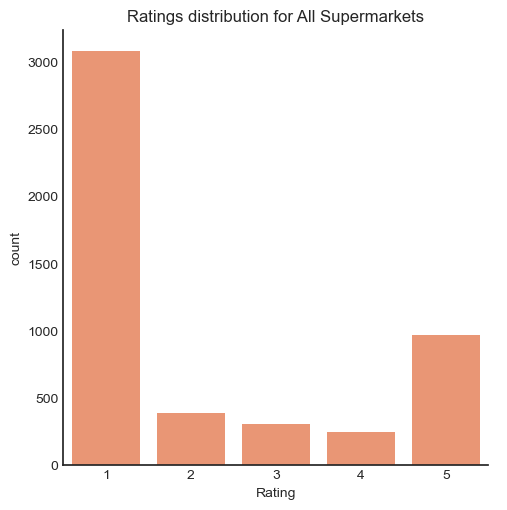

In [183]:
# Count of ratings
plt.figure(figsize=(3,2))
sns.catplot(data=company_reviews, x='Rating', kind='count',color='#FC8D62')
plt.title('Ratings distribution for All Supermarkets')
plt.show()

<Figure size 300x200 with 0 Axes>

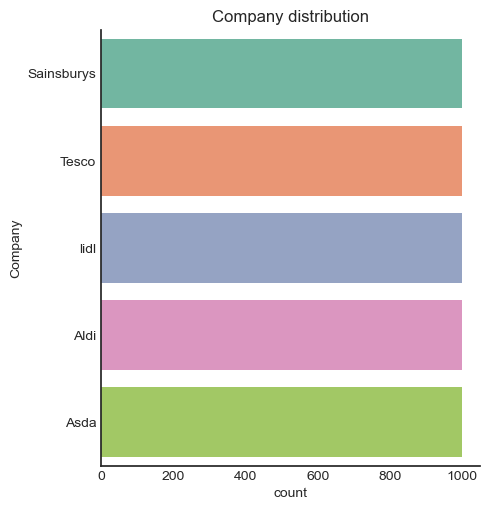

In [16]:
# Count of Companies
plt.figure(figsize=(3,2))
sns.catplot(data=company_reviews, y='Company', kind='count',palette='Set2')
plt.title('Company distribution')
plt.show()

Text(0.5, 1.0, 'Distribution of Asda Ratings')

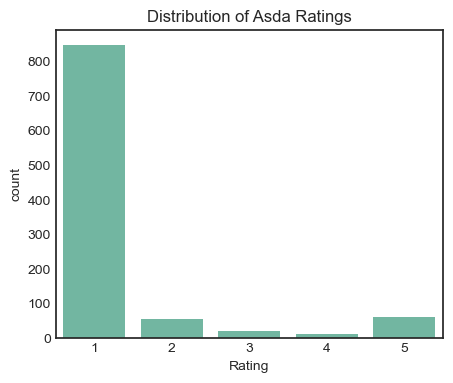

In [181]:
plt.figure(figsize=(5,4))
sns.countplot(data = company_reviews[company_reviews['Company']=='Asda'], x='Rating', color='#66C2A5')
plt.title('Distribution of Asda Ratings')

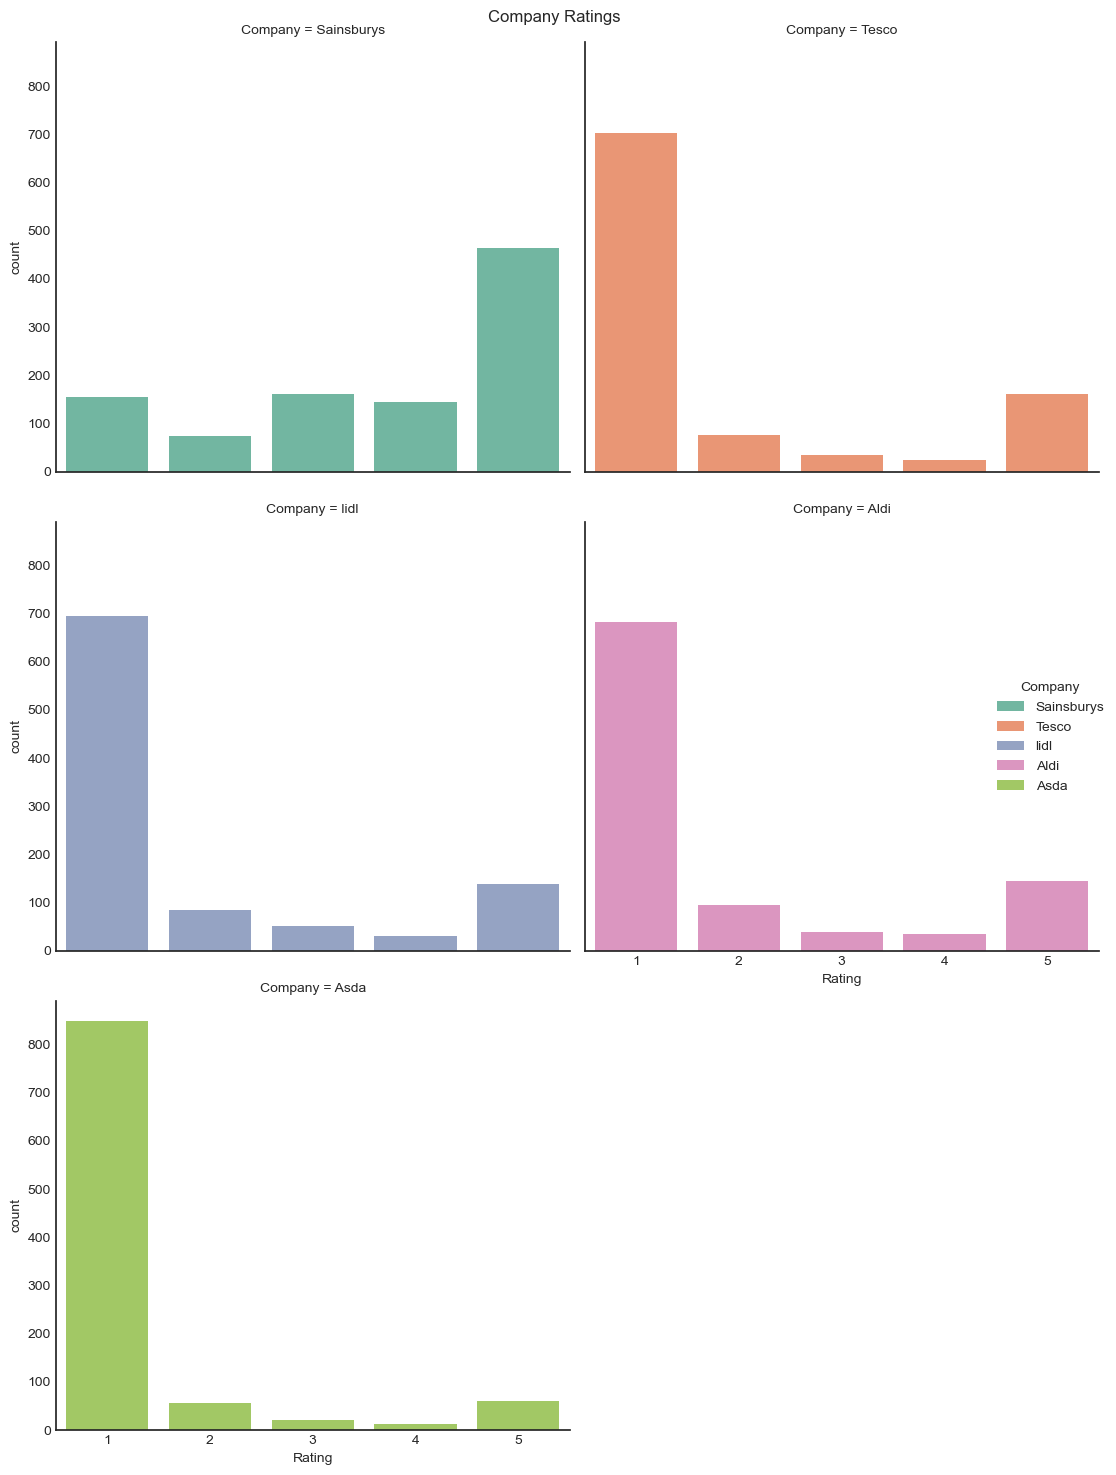

In [17]:
# Rating of each Company
sns.catplot(data=company_reviews, x='Rating', kind='count',col='Company',
            col_wrap=2,palette='Set2', hue='Company')
plt.suptitle('Company Ratings')
plt.tight_layout()
plt.savefig('company ratings.png')
plt.show()

## TEXT CLASSIFICATION

### DATA PREPARATION

In [20]:
# stop waords
stop_words = nltk.corpus.stopwords.words('english')

In [21]:
# function to preprocess text
def preprocess_text(text):
    tokenized_document = nltk.tokenize.RegexpTokenizer('[a-zA-Z0-9\']+').tokenize(text)
    cleaned_tokens = [word.lower() for word in tokenized_document if word.lower() not in stop_words]
    stemmed_text = [nltk.stem.PorterStemmer().stem(word) for word in cleaned_tokens]
    return ' '.join(stemmed_text)

In [22]:
# creating a copy of the data
df = company_reviews.copy()

In [23]:
# Applying the test preprocessing function 
df['Review'] = df['Review'].apply(preprocess_text)
df.head()

Company               Date  \
0  Sainsburys       17 hours ago   
1  Sainsburys  2 days agoInvited   
2  Sainsburys  2 days agoInvited   
3  Sainsburys  3 days agoInvited   
4  Sainsburys         2 days ago   

                                              Review  Rating  
0  first rate buffet food friend suggest order bu...       5  
1  sainsburi shop experiencesi'v alway shop sains...       5  
2  shop onlin josetteveri conveni shop onlin conv...       5  
3  great qualiti food great price great qualiti f...       5  
4  great way shop easi manag get everyth want nee...       5

In [24]:
# creating a rating category
rating_map = {
    1: 'Bad',
    2: 'Bad',
    3: 'Good',
    4: 'Good',
    5: 'Excellent'
}

In [25]:
df['Rating_category'] = df['Rating'].replace(rating_map)

In [26]:
# Setting  anumber for random state
random = 123

In [27]:
# Target and feature for text classification
X = df['Review']
y = df['Rating_category']

In [28]:
# Splitting to train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,y,train_size=0.8,test_size=0.2, random_state=random, stratify=y
)

In [29]:
print(X_train.shape)
print(X_test.shape)

(3999,)
(1000,)


In [30]:
# instantiating the vectorizer
vectorizer = CountVectorizer()
# fitting and transforming
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [31]:
print(X_train.shape)
print(X_test.shape)

(3999, 12288)
(1000, 12288)


### MODEL BUILDING

#### Imbalanced data

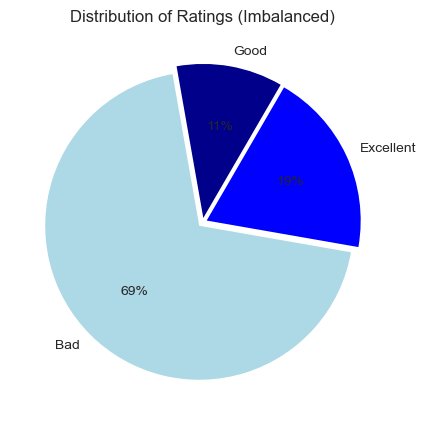

In [34]:
# Pie chart to visualize target.
plt.figure(figsize=(6, 5))
y_train.value_counts(normalize=True).plot.pie(
    autopct='%1.0f%%',
    startangle=100,
    colors=['lightblue', 'blue', 'darkblue'], 
    labels=['Bad', 'Excellent', 'Good'], 
    explode=[0.03, 0.03,0.03])
plt.title('Distribution of Ratings (Imbalanced)')
plt.ylabel('')
plt.show()

In [35]:
# Instantiating and fitting  naive bayes model
mnb = MultinomialNB()
mnb.fit(X_train,y_train)

MultinomialNB()

In [36]:
# predictions
y_pred = mnb.predict(X_test)

In [37]:
# accuracy of the model
accuracy_score(y_test,y_pred)

0.824

In [38]:
# classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         Bad       0.84      0.97      0.90       694
   Excellent       0.79      0.70      0.74       194
        Good       0.48      0.12      0.20       112

    accuracy                           0.82      1000
   macro avg       0.71      0.60      0.61      1000
weighted avg       0.79      0.82      0.79      1000



Text(0.5, 1.0, 'Confusion Matrix for reviews classification')

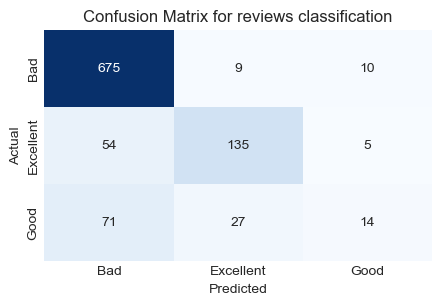

In [39]:
# confusion matrix
confusion_matrix_i = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_matrix_i, annot=True, fmt='d', cmap='Blues',cbar=False,
            xticklabels=['Bad', 'Excellent', 'Good'],
            yticklabels=['Bad', 'Excellent', 'Good'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for reviews classification')

#### Balancing with SMOTE

In [41]:
# instantiating the oversampler
smote = SMOTE(random_state=random)

In [42]:
# Resampling the model
X_train_smote, y_train_smote = smote.fit_resample(X_train,y_train)

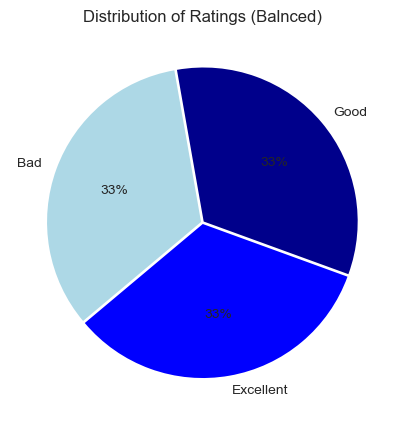

In [43]:
# Pie chart to visualize target.
plt.figure(figsize=(6, 5))
y_train_smote.value_counts(normalize=True).plot.pie(
    autopct='%1.0f%%',
    startangle=100,
    colors=['lightblue', 'blue', 'darkblue'], 
    labels=['Bad', 'Excellent', 'Good'], 
    explode=[0.01, 0.01,0.01])
plt.title('Distribution of Ratings (Balnced)')
plt.ylabel('')
plt.show()

In [44]:
# Instantiating and trainig the model
mnb_smote = MultinomialNB()
mnb_smote.fit(X_train_smote,y_train_smote)

MultinomialNB()

In [45]:
# prediction
y_pred_smote = mnb_smote.predict(X_test)

In [46]:
# accuracy of the model
accuracy_score(y_test,y_pred_smote)

0.827

In [47]:
# Model Evaluation
print(classification_report(y_test,y_pred_smote))

              precision    recall  f1-score   support

         Bad       0.88      0.94      0.91       694
   Excellent       0.81      0.69      0.74       194
        Good       0.43      0.38      0.40       112

    accuracy                           0.83      1000
   macro avg       0.71      0.67      0.69      1000
weighted avg       0.82      0.83      0.82      1000



Text(0.5, 1.0, 'Confusion Matrix for reviews classification')

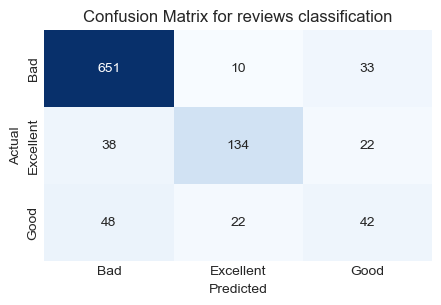

In [48]:
# confusion matrix
confusion_matrix_b = confusion_matrix(y_test,y_pred_smote)
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_matrix_b, annot=True, fmt='d', cmap='Blues',cbar=False,
            xticklabels=['Bad', 'Excellent', 'Good'],
            yticklabels=['Bad', 'Excellent', 'Good'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for reviews classification')

## SENTIMENT ANALYSIS

In [50]:
# Instantiating the analyser
sentiment = SentimentIntensityAnalyzer()

In [51]:
# creating a copy of the data
df2 = company_reviews.copy()

In [52]:
# sentiment analysis
df2['compound'] = [sentiment.polarity_scores(review)['compound'] for review in df2['Review']]
df2['neg'] = [sentiment.polarity_scores(review)['neg'] for review in df2['Review']]
df2['neu'] = [sentiment.polarity_scores(review)['neu'] for review in df2['Review']]
df2['pos'] = [sentiment.polarity_scores(review)['pos'] for review in df2['Review']]

In [53]:
# viewing the first 5 entries
df2.head()

Company               Date  \
0  Sainsburys       17 hours ago   
1  Sainsburys  2 days agoInvited   
2  Sainsburys  2 days agoInvited   
3  Sainsburys  3 days agoInvited   
4  Sainsburys         2 days ago   

                                              Review  Rating  compound    neg  \
0  First rate buffet food A friend suggested we o...       5    0.9804  0.000   
1  MY SAINSBURYS SHOPPING EXPERIENCESI've always ...       5    0.9804  0.000   
2  Shopping online is Josettevery convenient and…...       5    0.9196  0.000   
3  great quality food at great prices with…great ...       5    0.9229  0.036   
4  Great way to shop ! Easy I manage to get every...       5    0.8852  0.114   

     neu    pos  
0  0.744  0.256  
1  0.803  0.197  
2  0.840  0.160  
3  0.741  0.222  
4  0.676  0.210

In [54]:
# brief summary statistics
df2[['compound','neg','neu','pos']].describe()

compound          neg          neu          pos
count  4999.000000  4999.000000  4999.000000  4999.000000
mean     -0.026603     0.079984     0.820881     0.099135
std       0.702214     0.071007     0.096623     0.102116
min      -0.999200     0.000000     0.011000     0.000000
25%      -0.726900     0.017000     0.768000     0.027000
50%      -0.051600     0.072000     0.830000     0.070000
75%       0.711950     0.121500     0.886000     0.136500
max       1.000000     0.540000     1.000000     0.989000

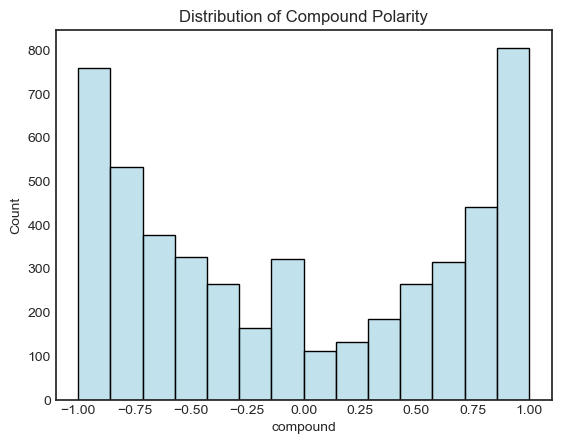

In [55]:
# distribution of sentiment
sns.histplot(df2['compound'], color='lightblue')
plt.title('Distribution of Compound Polarity')
plt.show()

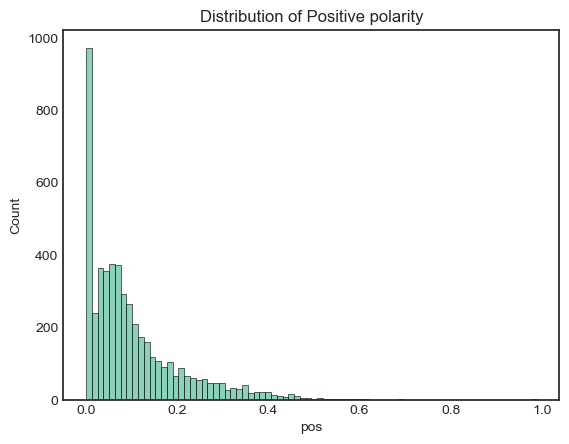

In [56]:
# distribution of positive scores
sns.histplot(df2['pos'],color='#66C2A5')
plt.title('Distribution of Positive polarity')
plt.show()

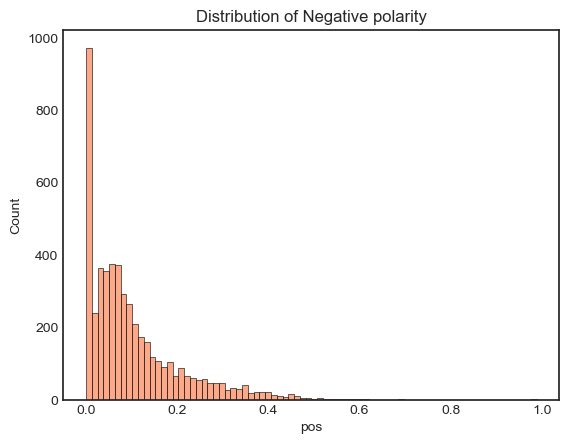

In [57]:
# distribution of positive scores
sns.histplot(df2['pos'],color='#FC8D62')
plt.title('Distribution of Negative polarity')
plt.show()

In [58]:
# Classifying sentiment into positive and negative
def classify_sentiment(compound):
    if compound > 0:
        return 'Positive'
    else:
        return 'Negative'
df2['sentiment'] = df2['compound'].apply(classify_sentiment)
df2['Rating_category'] = df['Rating_category']
df2.head()

Company               Date  \
0  Sainsburys       17 hours ago   
1  Sainsburys  2 days agoInvited   
2  Sainsburys  2 days agoInvited   
3  Sainsburys  3 days agoInvited   
4  Sainsburys         2 days ago   

                                              Review  Rating  compound    neg  \
0  First rate buffet food A friend suggested we o...       5    0.9804  0.000   
1  MY SAINSBURYS SHOPPING EXPERIENCESI've always ...       5    0.9804  0.000   
2  Shopping online is Josettevery convenient and…...       5    0.9196  0.000   
3  great quality food at great prices with…great ...       5    0.9229  0.036   
4  Great way to shop ! Easy I manage to get every...       5    0.8852  0.114   

     neu    pos sentiment Rating_category  
0  0.744  0.256  Positive       Excellent  
1  0.803  0.197  Positive       Excellent  
2  0.840  0.160  Positive       Excellent  
3  0.741  0.222  Positive       Excellent  
4  0.676  0.210  Positive       Excellent

In [59]:
df2['sentiment'].value_counts(normalize=True)

sentiment
Negative    0.54951
Positive    0.45049
Name: proportion, dtype: float64

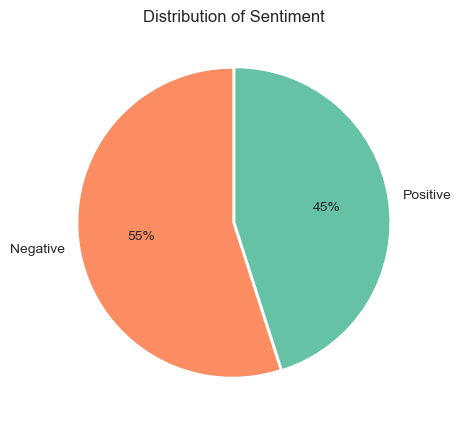

In [60]:
# Sentiment distribution
plt.figure(figsize=(6, 5))
df2['sentiment'].value_counts(normalize=True).plot.pie(
    autopct='%1.0f%%',
    startangle=90,
    colors=['#FC8D62', '#66C2A5'], 
    labels=['Negative', 'Positive'], 
    explode=[0.01, 0.01])
plt.title('Distribution of Sentiment')
plt.ylabel('')
plt.show()

Text(0.5, 1.0, 'Sentiment per Company')

<Figure size 300x200 with 0 Axes>

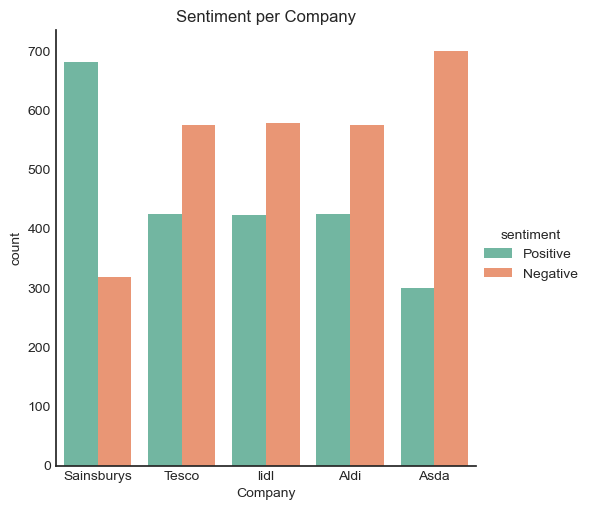

In [61]:
# sentiment per company
plt.figure(figsize=(3,2))
sns.catplot(data=df2, x='Company',hue='sentiment',kind='count',palette='Set2')
plt.title('Sentiment per Company')

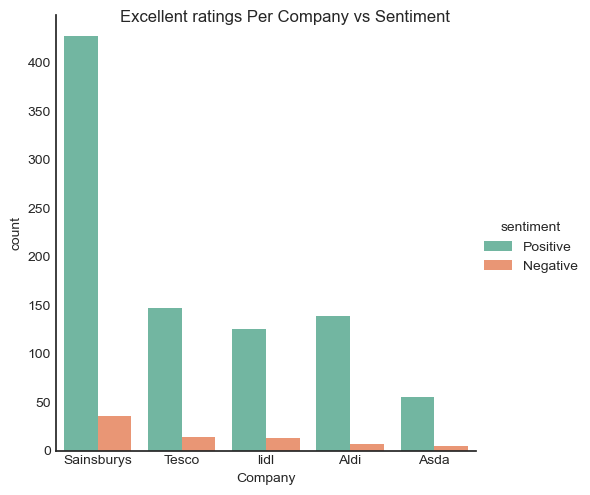

In [62]:
# Company Excellent Ratings Based on Sentiment
sns.catplot(data=df2[df2['Rating_category']=='Excellent'], x='Company',hue='sentiment',
            kind='count', palette='Set2')
plt.suptitle('Excellent ratings Per Company vs Sentiment')
plt.show()

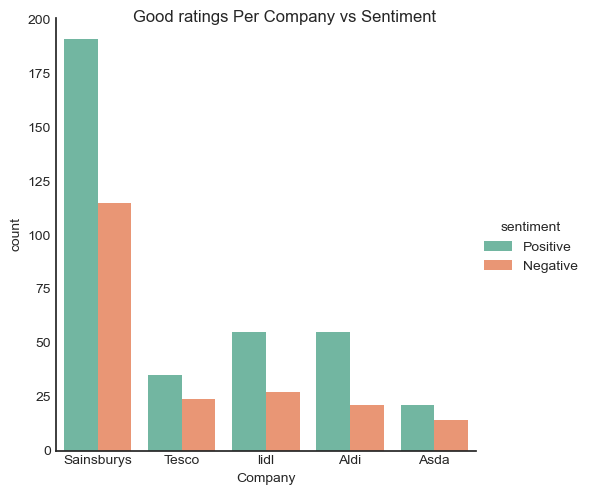

In [63]:
# Company Good Ratings Based on Sentiment
sns.catplot(data=df2[df2['Rating_category']=='Good'], x='Company',hue='sentiment',
            kind='count', palette='Set2',hue_order=['Positive','Negative'])
plt.suptitle('Good ratings Per Company vs Sentiment')
plt.show()

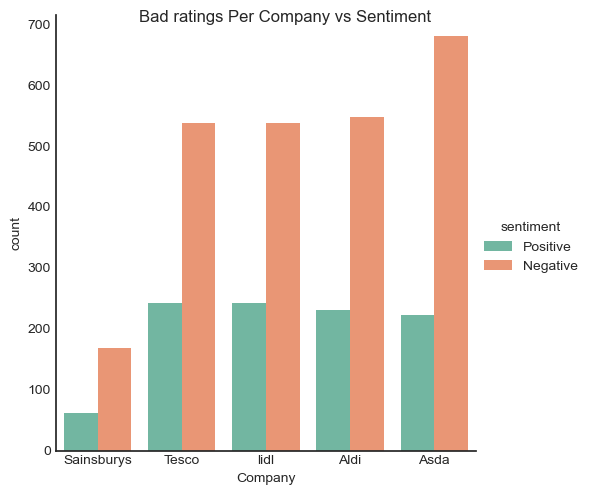

In [64]:
# Company Bad Ratings Based on Sentiment
sns.catplot(data=df2[df2['Rating_category']=='Bad'], x='Company',hue='sentiment',
            kind='count', palette='Set2',hue_order=['Positive','Negative'])
plt.suptitle('Bad ratings Per Company vs Sentiment')
plt.show()

### Word Cloud and Frequency Distribution

In [66]:
irrelevant_words = ['tesco','sainsbury','sainsburys','aldi','lidl','asda','date','experience',
                    'january','february','march','april','may','june','july','august',
                   'september','october','november','2024','get','always','store','shopping',"sainsbury's",
                   '01','02','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19',
                   '20','21','22','23','24','25','26','27','28','29','30','31','would','one','shop','items',
                   'go','back','went','2023','2']
new_stop_words = stop_words + irrelevant_words

In [67]:
def preprocess_wordcloud(text):
    tokenized_document = nltk.tokenize.RegexpTokenizer('[a-zA-Z0-9\']+').tokenize(text)
    cleaned_tokens = [word.lower() for word in tokenized_document if word.lower() not in new_stop_words]
    return ' '.join(cleaned_tokens)

In [68]:
# Applying the test preprocessing function 
df2['Review'] = df2['Review'].apply(preprocess_wordcloud)
df2.head()

Company               Date  \
0  Sainsburys       17 hours ago   
1  Sainsburys  2 days agoInvited   
2  Sainsburys  2 days agoInvited   
3  Sainsburys  3 days agoInvited   
4  Sainsburys         2 days ago   

                                              Review  Rating  compound    neg  \
0  first rate buffet food friend suggested ordere...       5    0.9804  0.000   
1  experiencesi've shopped halifax wade street ev...       5    0.9804  0.000   
2  online josettevery convenient online convenien...       5    0.9196  0.000   
3  great quality food great prices great quality ...       5    0.9229  0.036   
4  great way easy manage everything want need mon...       5    0.8852  0.114   

     neu    pos sentiment Rating_category  
0  0.744  0.256  Positive       Excellent  
1  0.803  0.197  Positive       Excellent  
2  0.840  0.160  Positive       Excellent  
3  0.741  0.222  Positive       Excellent  
4  0.676  0.210  Positive       Excellent

In [69]:
# function to create wordcloud
def gen_wordcloud(company, sentiment, color):
    company_sentiment = df2.loc[(df2['Company']==company) & (df2['sentiment']==sentiment)]
    token = ' '.join(company_sentiment['Review'])
    wordcloud = WordCloud(background_color='white',colormap=color,
                          stopwords=new_stop_words,random_state=random).generate_from_text(token)
    #plotting
    plt.figure(figsize=(10,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    

In [70]:
# generate frequecy distribution
def gen_freq_dist(company, sentiment,color):
    company_sentiment = df2.loc[(df2['Company']==company) & (df2['sentiment']==sentiment)]
    token = ' '.join(company_sentiment['Review'])
    freq_dist = nltk.probability.FreqDist(token.split())
    freq_dist.plot(20, color=color)
    plt.title('Top 20 Word Counts')
    plt.xlabel('Word')
    plt.ylabel('Count')
    plt.show()
    

#### Analysis of Sainsbury's Review

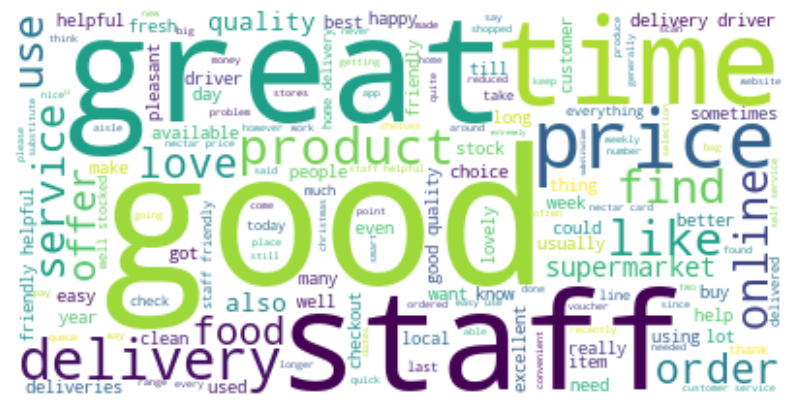

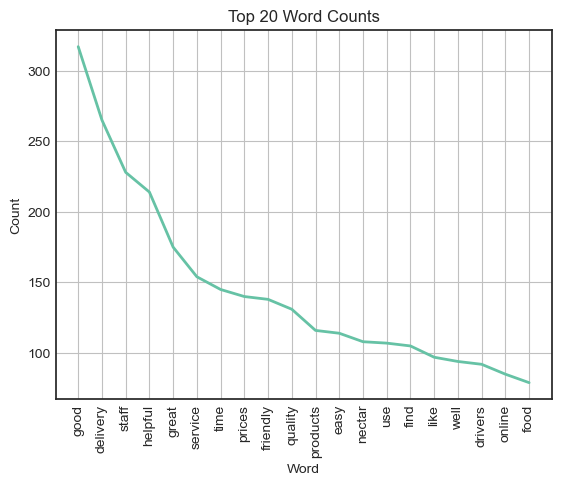

In [72]:
# Positive review Wordcloud and freqdistribution
gen_wordcloud('Sainsburys','Positive','viridis')
gen_freq_dist('Sainsburys','Positive','#66C2A5')

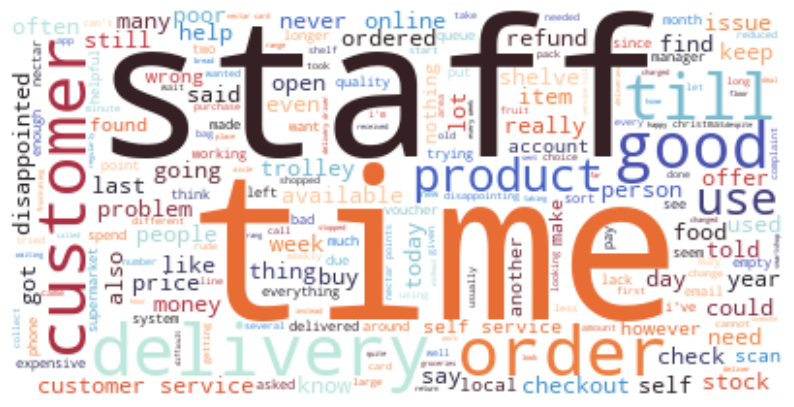

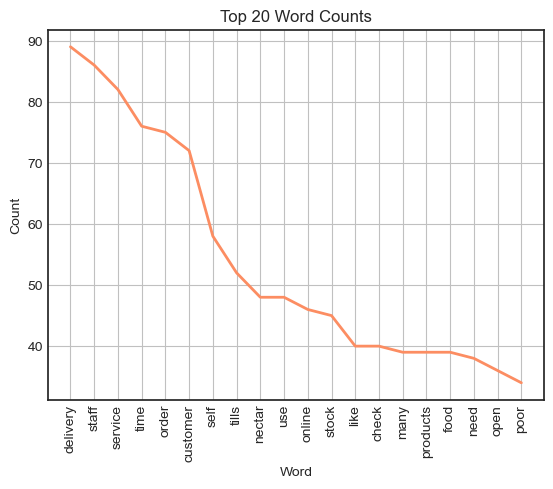

In [73]:
# Negative review Wordcloud and freqdistribution
gen_wordcloud('Sainsburys','Negative','icefire')
gen_freq_dist('Sainsburys','Negative','#FC8D62')

#### Analysis of Tesco Review

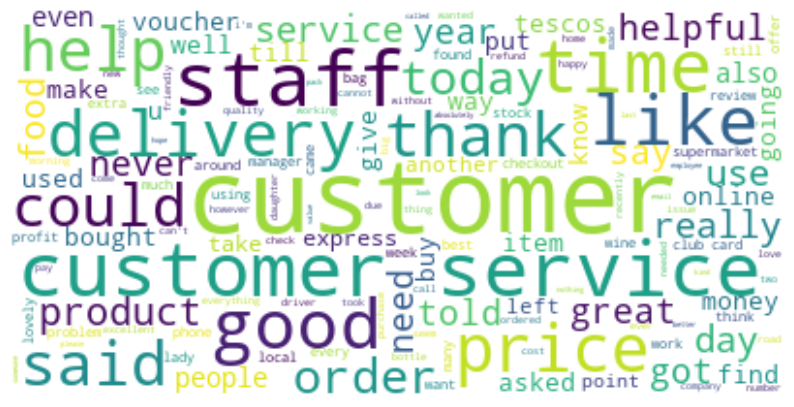

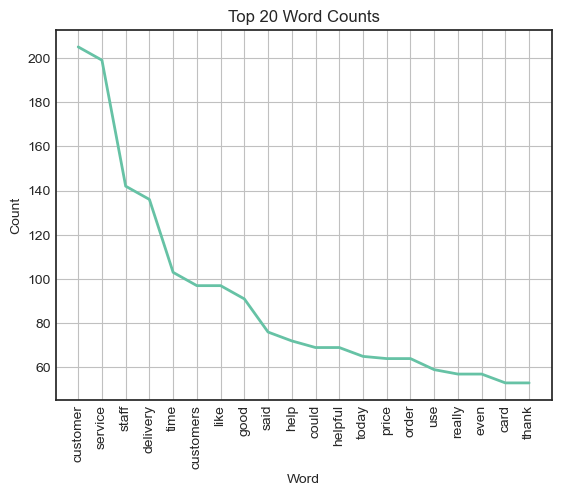

In [75]:
# Positive review Wordcloud and freqdistribution
gen_wordcloud('Tesco','Positive','viridis')
gen_freq_dist('Tesco','Positive','#66C2A5')

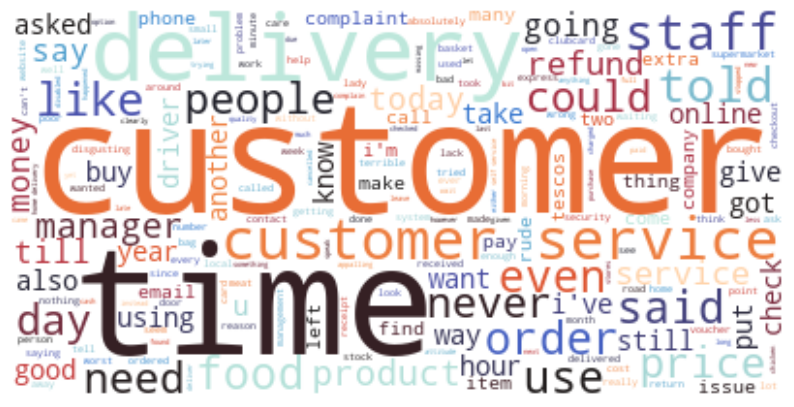

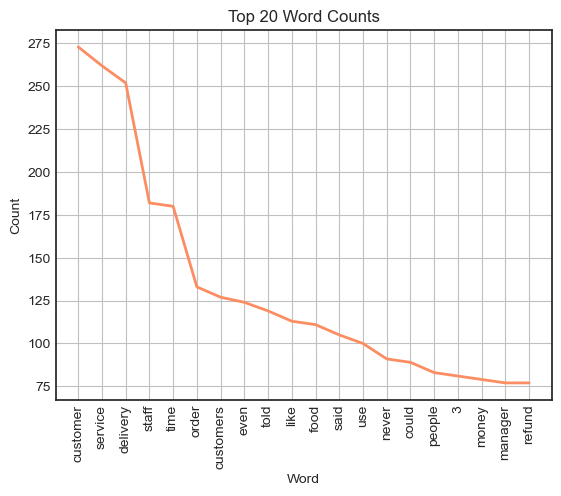

In [76]:
# Negative review Wordcloud and freqdistribution
gen_wordcloud('Tesco','Negative','icefire')
gen_freq_dist('Tesco','Negative','#FC8D62')

#### Analysis of lidl Review

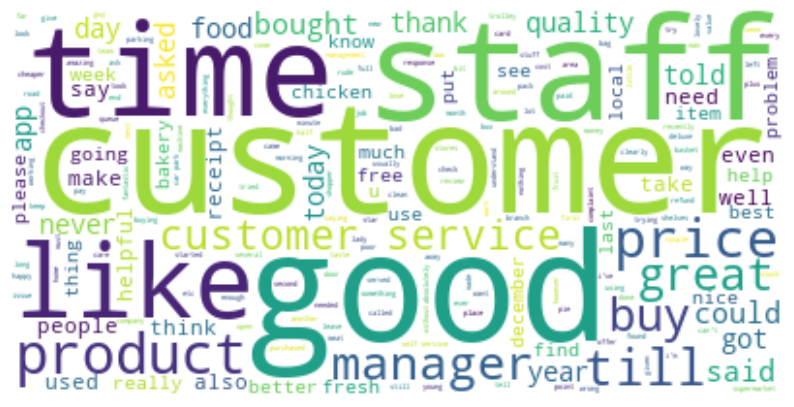

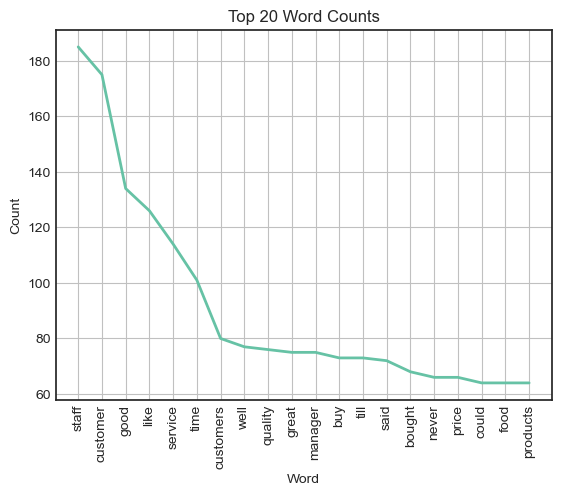

In [78]:
# Positive review Wordcloud and freqdistribution
gen_wordcloud('lidl','Positive','viridis')
gen_freq_dist('lidl','Positive','#66C2A5')

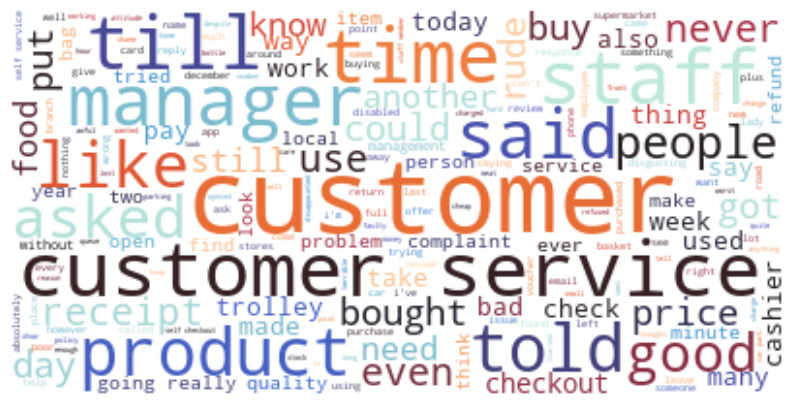

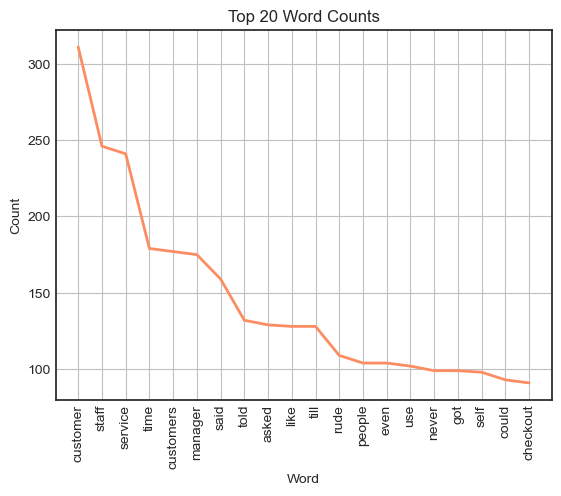

In [79]:
# Negative review Wordcloud and freqdistribution
gen_wordcloud('lidl','Negative','icefire')
gen_freq_dist('lidl','Negative','#FC8D62')

#### Analysis of Aldi Review

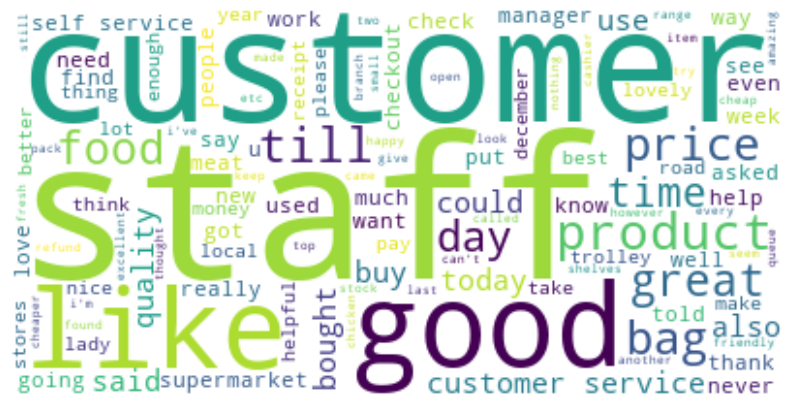

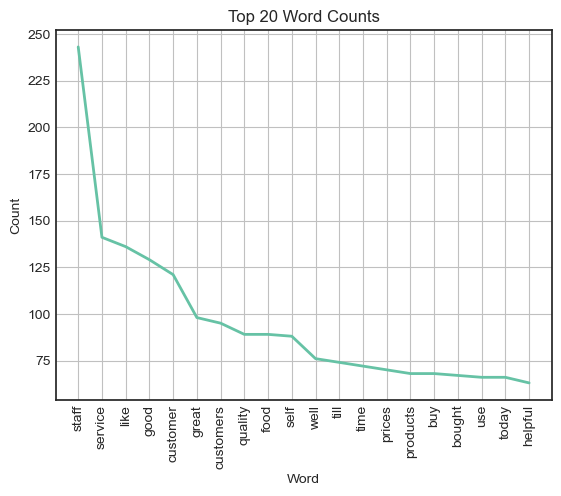

In [81]:
# Positive review Wordcloud and freqdistribution
gen_wordcloud('Aldi','Positive','viridis')
gen_freq_dist('Aldi','Positive','#66C2A5')

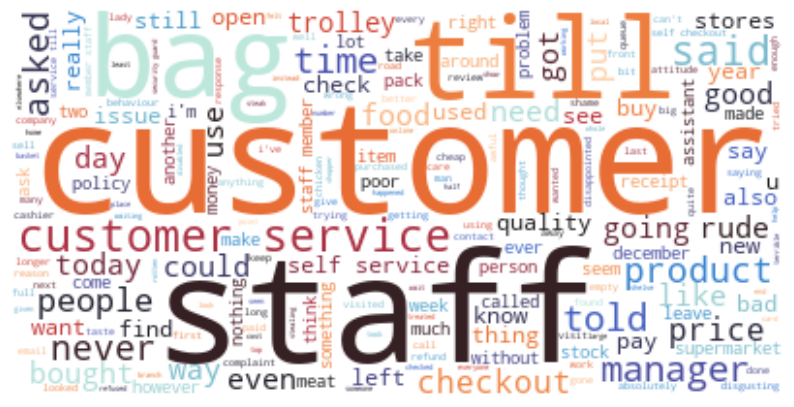

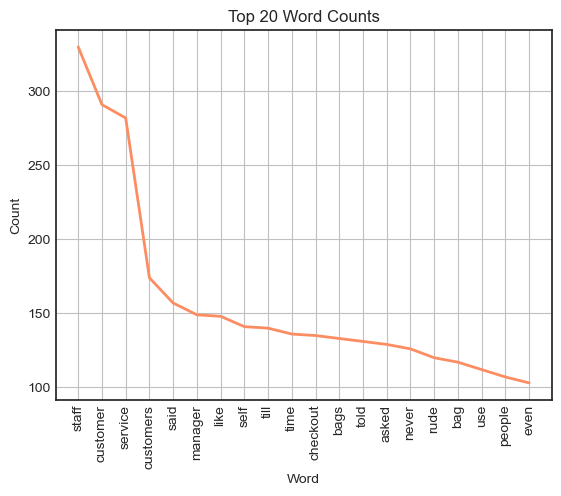

In [82]:
# Negative review Wordcloud and freqdistribution
gen_wordcloud('Aldi','Negative','icefire')
gen_freq_dist('Aldi','Negative','#FC8D62')

#### Analysis of Asda Review

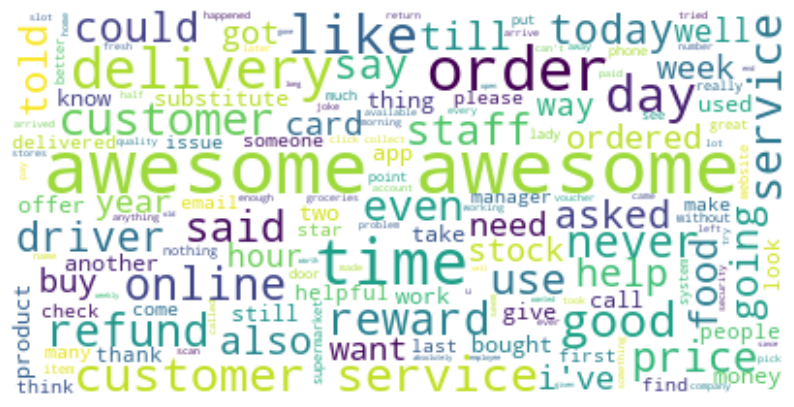

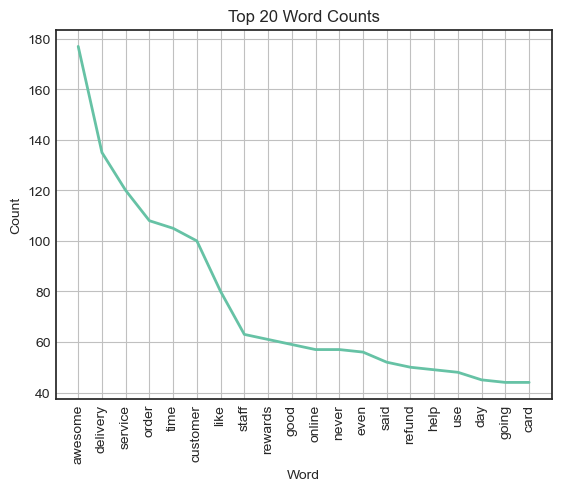

In [84]:
# Positive review Wordcloud and freqdistribution
gen_wordcloud('Asda','Positive','viridis')
gen_freq_dist('Asda','Positive','#66C2A5')

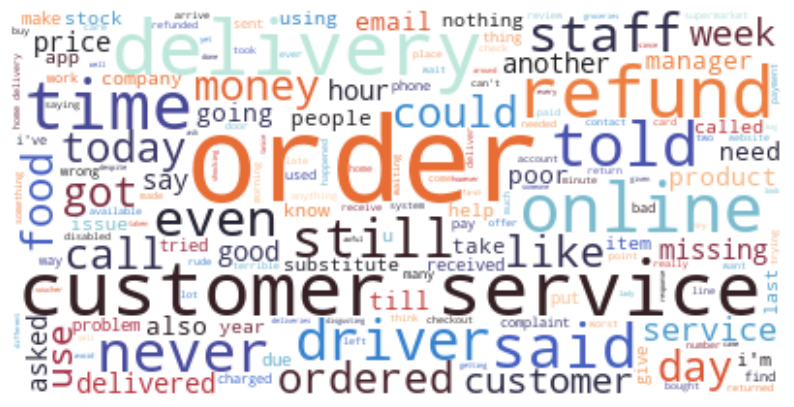

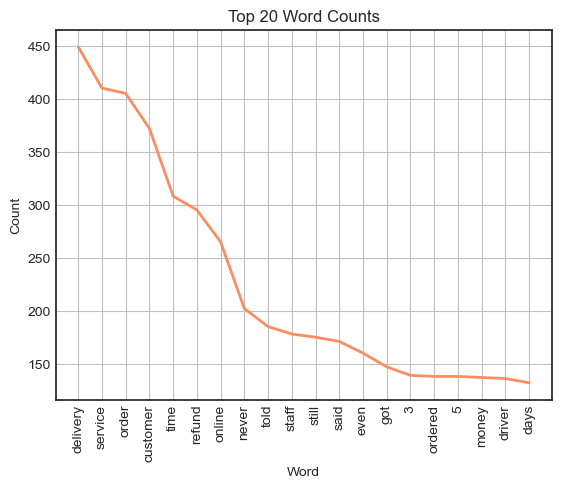

In [85]:
# Negative review Wordcloud and freqdistribution
gen_wordcloud('Asda','Negative','icefire')
gen_freq_dist('Asda','Negative','#FC8D62')